# Classification
The dataset contains a considerable amount of missing danger rating data. In this notebook, we will further preprocess the data and explore different traditional classification approaches to determine the feasibility of imputing or predicting the missing danger ratings based on the available data and predictions from the trained classifier. If the trained models demonstrate sufficient precision, they could serve as automated support tool for avalanche experts in categorizing danger ratings for the future avalanche incidents.

## Preprocessing
### Loading the Dataset

In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

from avalancheutils.classification import calculate_performance_metrics, tune_hyperparameters, get_model_predict_comparison
from avalancheutils.data_preprocessing import adjust_scaled_data, angle_decomposition, \
    compare_column_operation, data_overview, \
    impute_categorical_feature, missing_data_overview, one_hot_encode, unique_value_counts
from avalancheutils.visualization import plot_heatmap, plot_histogram, plot_confusion_matrix

In [2]:
incidents = pd.read_csv('data/incidents_tirol_processed.csv', parse_dates=['date'])
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            1109 non-null   int64         
 1   date                          1109 non-null   datetime64[ns]
 2   valid_time                    1109 non-null   bool          
 3   location_longitude            1109 non-null   float64       
 4   location_latitude             1109 non-null   float64       
 5   danger_rating                 1054 non-null   float64       
 6   danger_problem                478 non-null    object        
 7   involved_sum                  750 non-null    float64       
 8   involved_dead                 974 non-null    float64       
 9   involved_injured              976 non-null    float64       
 10  involved_uninjured            772 non-null    float64       
 11  involved_swept                

In [3]:
incidents

,id,date,valid_time,location_longitude,location_latitude,danger_rating,danger_problem,involved_sum,involved_dead,involved_injured,...,weather_temp,weather_snow_depth,weather_temp_mean,weather_temp_diff,weather_rain_sum,weather_snow_sum,weather_wind_speed_mean,weather_wind_dir_mean,weather_radiation_sum,week_day
0,9354,2018-02-17 11:34:00,True,11.98533,47.27433,3.0,NaN,0.0,0.0,0.0,...,-1.072000,1.62,-11.436062,12.231251,0.400000,15.330001,1.765809,236.022186,30.590000,5
1,9355,2018-02-17 12:42:00,True,10.51200,47.04033,3.0,NaN,2.0,0.0,0.0,...,-5.520000,1.73,-13.941355,11.135417,0.100000,11.830001,2.170215,239.169565,27.330000,5
2,9347,2018-02-16 09:58:00,True,10.17150,46.88017,3.0,NaN,2.0,0.0,1.0,...,-5.238000,2.12,-13.038000,9.931250,0.000000,9.170000,1.789226,271.672250,33.340000,4
3,9370,2018-02-22 14:20:00,True,10.30706,47.10953,2.0,NaN,2.0,0.0,0.0,...,-11.348000,2.03,-15.169874,-2.739584,0.000000,1.260000,1.921453,140.138434,45.429996,3
4,9371,2018-02-21 15:24:00,True,10.28800,47.10217,2.0,NaN,3.0,0.0,0.0,...,-12.007500,2.05,-12.555938,-4.852083,0.000000,2.590000,1.958323,328.446203,40.350000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,10872,2024-01-16 12:04:00,True,10.64267,47.46683,2.0,wind_slab,NaN,NaN,NaN,...,-5.898000,1.37,-7.563105,-2.999999,1.400000,3.780000,3.958705,222.232472,23.660000,1
1105,10871,2024-01-27 14:40:00,True,10.86917,46.93223,2.0,persistent_weak_layers,2.0,0.0,0.0,...,-9.252501,10.14,-7.532708,-8.310416,3.999999,16.310000,4.410570,295.006771,22.520000,5
1106,10817,2024-01-27 15:25:00,True,11.09482,46.99571,2.0,persistent_weak_layers,2.0,0.0,0.0,...,-11.929500,1.69,-8.196167,-7.350000,5.099999,16.939999,4.362330,305.166596,23.040000,5
1107,10873,2024-02-29 10:54:00,True,11.07445,46.88392,2.0,wind_slab,1.0,0.0,0.0,...,-3.077000,1.89,-6.460854,2.887499,0.000000,14.140000,3.061700,172.783760,43.250000,3


In [4]:
df = incidents.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            1109 non-null   int64         
 1   date                          1109 non-null   datetime64[ns]
 2   valid_time                    1109 non-null   bool          
 3   location_longitude            1109 non-null   float64       
 4   location_latitude             1109 non-null   float64       
 5   danger_rating                 1054 non-null   float64       
 6   danger_problem                478 non-null    object        
 7   involved_sum                  750 non-null    float64       
 8   involved_dead                 974 non-null    float64       
 9   involved_injured              976 non-null    float64       
 10  involved_uninjured            772 non-null    float64       
 11  involved_swept                

In [5]:
data_overview(df, include_dtype=True)

,Unique Values,Non-Null Values,Data Type
involved_equipment_airbag,3,168,object
involved_not_buried,4,192,float64
involved_avd_activated,2,200,object
involved_standard_equipment,2,220,object
involved_ascent_descent,3,404,object
avalanche_humidity,2,458,object
danger_problem,5,478,object
avalanche_artificial_release,2,483,object
avalanche_breakheight,43,640,float64
avalanche_size,5,695,float64


For the classifier training only records with non-empty danger rating values will be used. This way there will be less artificial bias introduced into the target variable.

In [6]:
df = df.dropna(subset=['danger_rating'])

In [7]:
unique_value_counts(df['valid_time'])

Unique values for the property "" (2 unique values and 1054 / 1054 non-null values):



valid_time
True     729
False    325
Name: count, dtype: int64

In [8]:
observed_columns_idx = missing_data_overview(data=df, threshold=101)
observed_columns_idx

,Non-Null Values (%),Unique Values,Non-Null Values
Feature Name,,,
id,100.000000,1054,1054
date,100.000000,969,1054
weather_radiation_sum,100.000000,891,1054
weather_wind_dir_mean,100.000000,953,1054
weather_wind_speed_mean,100.000000,953,1054
weather_snow_sum,100.000000,649,1054
weather_rain_sum,100.000000,100,1054
weather_temp_diff,100.000000,1014,1054
weather_temp_mean,100.000000,1042,1054


### Removing the Problem Features
The dataset still contains a significant number of non-numerical features and null values. To enhance the accuracy of our classification results, it is crucial to address these issues before performing the classification.

In [9]:
non_numerical_columns = df.select_dtypes(exclude=['number']).columns.tolist()
data_overview(df[non_numerical_columns])

,Unique Values,Non-Null Values
involved_equipment_airbag,3,166
involved_avd_activated,2,195
involved_standard_equipment,2,215
involved_ascent_descent,3,397
avalanche_humidity,2,451
danger_problem,5,472
avalanche_artificial_release,2,477
avalanche_type,3,954
date,969,1054
valid_time,2,1054


#### Features with Too Many Unique Values
We will remove the `id` feature as it is just an identifier and would introduce additional bias into the training data. Additionally, we will remove the `location_name` and `location_subregion` features as they contain too many unique values for non-numerical features in proportion to the total number of records in the dataset.

In [10]:
columns_to_drop = ['id', 'location_name', 'location_subregion']
df = df.drop(columns=columns_to_drop)

#### Features with Too Many Missing Values
There are numerous features in the dataset with over 50% of the data missing. Let's have a closer look at them.

In [11]:
threshold = 50

In [12]:
overview, observed_columns_idx = missing_data_overview(data=df, threshold=threshold, missing_cols_idx=True)
overview

,Non-Null Values (%),Unique Values,Non-Null Values
Feature Name,,,
avalanche_artificial_release,45.256167,2,477
danger_problem,44.781784,5,472
avalanche_humidity,42.789374,2,451
involved_ascent_descent,37.666034,3,397
involved_standard_equipment,20.398482,2,215
involved_avd_activated,18.500949,2,195
involved_not_buried,18.121442,4,191
involved_equipment_airbag,15.749526,3,166


One of the ways to check what dropping them is a good idea is to compute the correlation coefficients of the affected features with the target variable, in order to rule out dropping features with a possibly high impact on the predicted values. Some of the features are nominal categorical features and therefore in order to compute the correlation matrix, it is necessary to first encode them using one-hot encoding.

In [13]:
nominal_categories = ['danger_problem', 'avalanche_artificial_release', 'avalanche_humidity',
                      'involved_ascent_descent', 'involved_standard_equipment', 'involved_avd_activated',
                      'involved_equipment_airbag']
encoded_incidents = one_hot_encode(df[observed_columns_idx.append(pd.Index(['danger_rating']))],
                                   nominal_categories)
encoded_incidents

,danger_problem_gliding_snow,danger_problem_new_snow,danger_problem_persistent_weak_layers,danger_problem_wet_snow,danger_problem_wind_slab,danger_problem_nan,avalanche_artificial_release_False,avalanche_artificial_release_True,avalanche_artificial_release_nan,avalanche_humidity_False,...,involved_standard_equipment_nan,involved_avd_activated_False,involved_avd_activated_True,involved_avd_activated_nan,involved_equipment_airbag_all,involved_equipment_airbag_none,involved_equipment_airbag_some,involved_equipment_airbag_nan,involved_not_buried,danger_rating
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,3.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,3.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,3.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,2.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,2.0
1050,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0
1051,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0
1052,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0


In [14]:
encoded_incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   danger_problem_gliding_snow            1054 non-null   float64
 1   danger_problem_new_snow                1054 non-null   float64
 2   danger_problem_persistent_weak_layers  1054 non-null   float64
 3   danger_problem_wet_snow                1054 non-null   float64
 4   danger_problem_wind_slab               1054 non-null   float64
 5   danger_problem_nan                     1054 non-null   float64
 6   avalanche_artificial_release_False     1054 non-null   float64
 7   avalanche_artificial_release_True      1054 non-null   float64
 8   avalanche_artificial_release_nan       1054 non-null   float64
 9   avalanche_humidity_False               1054 non-null   float64
 10  avalanche_humidity_True                1054 non-null   float64
 11  aval

In [15]:
correlation_matrix = encoded_incidents.corrwith(encoded_incidents['danger_rating'], method='spearman')
corr = correlation_matrix.abs().sort_values(ascending=False).iloc[1:].rename_axis('Feature Name', axis='index')
corr.name = 'Absolute Correlation Coefficient for the Danger Rating'
corr

Feature Name
danger_problem_new_snow                  0.145743
danger_problem_wind_slab                 0.124715
involved_ascent_descent_ascent           0.111759
avalanche_humidity_True                  0.096441
danger_problem_gliding_snow              0.091072
avalanche_artificial_release_nan         0.086704
involved_avd_activated_True              0.086383
avalanche_artificial_release_True        0.080371
involved_standard_equipment_True         0.080026
danger_problem_nan                       0.073892
avalanche_humidity_nan                   0.070768
involved_avd_activated_nan               0.061606
involved_standard_equipment_nan          0.060259
involved_avd_activated_False             0.053128
involved_not_buried                      0.052751
involved_ascent_descent_nan              0.051147
involved_equipment_airbag_all            0.042536
involved_equipment_airbag_nan            0.040445
involved_standard_equipment_False        0.040217
avalanche_humidity_False             

As we can see none of these features has a correlation coefficient high enough to justify its further presence in the training dataset. Therefore, they will be removed.

In [16]:
df = df.drop(columns=observed_columns_idx)

##### Date and Time Decomposition
As observed in the previous analysis, avalanche incidents exhibit strong seasonality, influenced not only by the month, but also by the specific day within the month (for example, public holidays with fixed dates often see increased ski touring activity due to people having more free time). Additionally, variations in snowfall patterns from year to year contribute to seasonal differences (some years experience heavier and longer-lasting snowfall on the slopes). Furthermore, the time of day also plays a significant role in the probability of avalanche occurrence. To adequately address these factors in the model training process, it is necessary to decompose the date and time into separate features.

In [17]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day  # selecting only time values that are valid

In [18]:
hour_minute = df[df['valid_time'] == True]['date']
df['hour'] = hour_minute.dt.hour
df['minute'] = hour_minute.dt.minute

In [19]:
unique_value_counts(df['valid_time'], 'Valid Time')

Unique values for the property "Valid Time" (2 unique values and 1054 / 1054 non-null values):



valid_time
True     729
False    325
Name: count, dtype: int64

It is evident that retaining only 790 non-empty values would not sufficiently contribute to the dataset. Additionally, considering that the danger rating doesn't frequently change during the day, retaining this information seems redundant.

We can remove the `date` feature and the `valid_time` flag since it no longer serves its purpose.

In [20]:
columns_to_drop = ['date', 'valid_time']

In [21]:
df = df.drop(columns=columns_to_drop)

#### Circular Values
Both `location_aspect` and `weather_wind_dir_mean` contain circular angle values. These values can't be used directly as ordinal values due to their circular nature. Therefore, they will be decomposed using sine and cosine to represent their coordinates on the unit circle.
##### Slope Aspect
For the slope aspect, we first need to convert its `str` values into numerical.

In [22]:
direction_to_degrees = {
    'N': 0,
    'NE': 45,
    'E': 90,
    'SE': 135,
    'S': 180,
    'SW': 225,
    'W': 270,
    'NW': 315
}

In [23]:
df['location_aspect'] = pd.to_numeric(df['location_aspect'].replace(direction_to_degrees), errors='coerce')

Two new features will be created, representing the x and y coordinate of each angle.

In [24]:
df['location_aspect_x'], df['location_aspect_y'] = angle_decomposition(df['location_aspect'])

#### Mean Wind Direction
We will do the same for the mean wind direction:

In [25]:
df['weather_wind_dir_mean_x'], df['weather_wind_dir_mean_y'] = angle_decomposition(df['weather_wind_dir_mean'])

Now we can remove the original features as they are redundant now.

In [26]:
df = df.drop(columns=['location_aspect', 'weather_wind_dir_mean'])

# Classification
To ensure the reproducibility of results, a predetermined random state seed will be used.

In [27]:
random_seed = 123456

### Removing the Target Feature
To further preprocess the data, the target feature will be removed to prevent introducing additional bias into the dataset.

In [28]:
non_empty_danger = df.drop(columns=['danger_rating'])
data_overview(non_empty_danger)

,Unique Values,Non-Null Values
avalanche_breakheight,42,616
avalanche_size,5,673
involved_sum,13,722
hour,15,729
minute,60,729
involved_uninjured,11,744
avalanche_extent_width,58,772
avalanche_extent_length,85,786
involved_buried_total,10,923
involved_buried_partial,9,925


### Target Variable Distribution

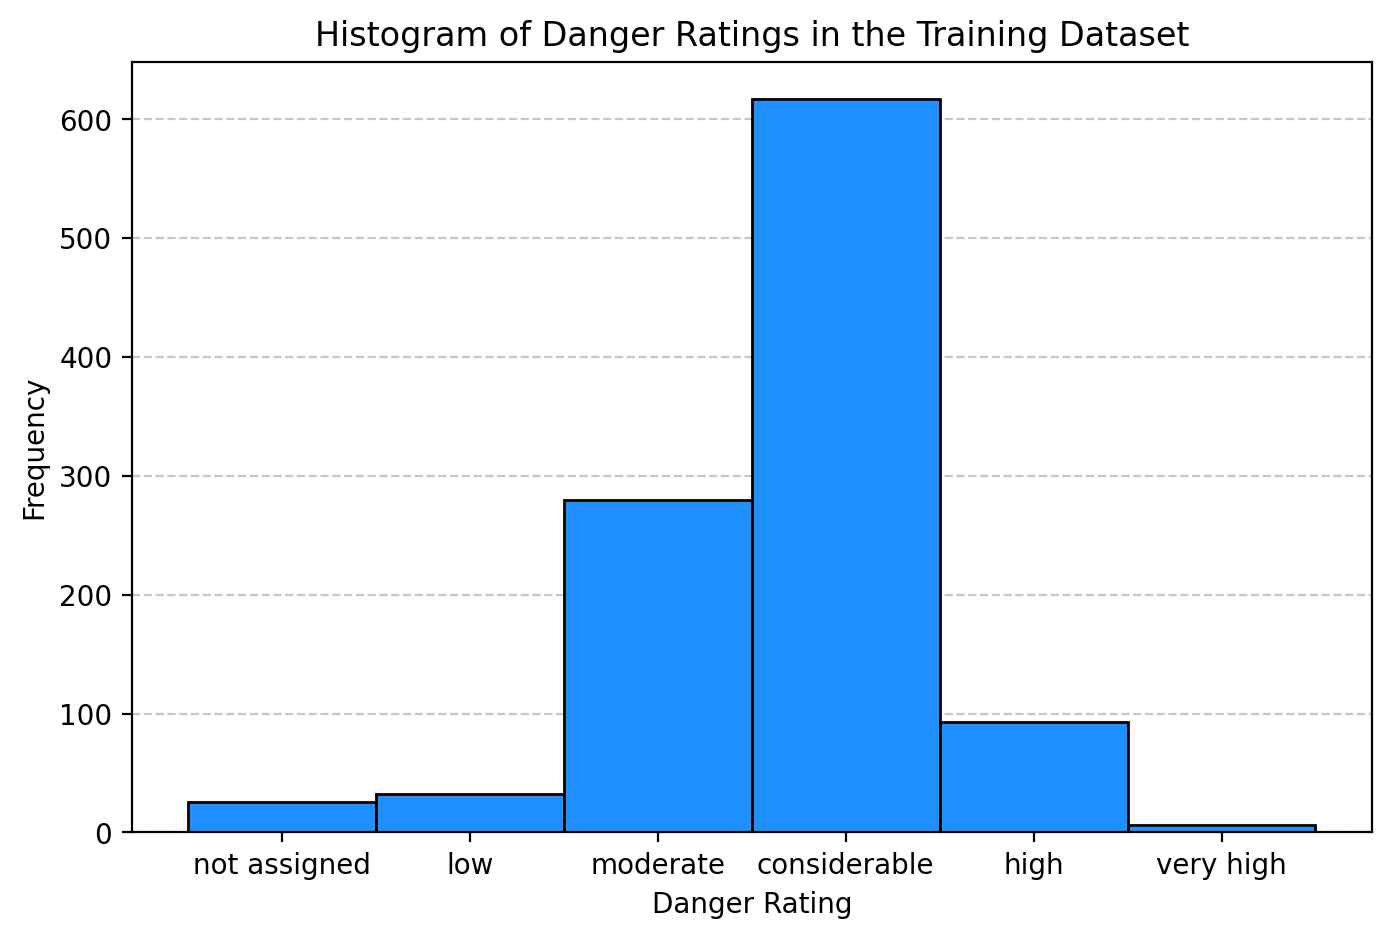

In [29]:
plot_histogram(data=df['danger_rating'], title='Histogram of Danger Ratings in the Training Dataset',
               x_label='Danger Rating',
               y_label='Frequency', bins=range(7),
               x_ticks_labels=['not assigned', 'low', 'moderate', 'considerable', 'high', 'very high'])
plt.show()

In [30]:
unique_value_counts(df['danger_rating'], 'Danger Rating')

Unique values for the property "Danger Rating" (6 unique values and 1054 / 1054 non-null values):



danger_rating
3.0    617
2.0    280
4.0     93
1.0     32
0.0     26
5.0      6
Name: count, dtype: int64

### Dealing with Missing Values
There are still some values missing for some of the features. In order to be able to train a classifier, the missing data should be imputed first.

In [31]:
missing_data_overview(non_empty_danger, threshold=100)

,Non-Null Values (%),Unique Values,Non-Null Values
Feature Name,,,
avalanche_type,90.512334,3,954
involved_injured,88.804554,6,936
involved_dead,88.614801,10,934
involved_swept,88.330171,14,931
involved_buried_partial,87.760911,9,925
involved_buried_total,87.571157,10,923
avalanche_extent_length,74.573055,85,786
avalanche_extent_width,73.244782,58,772
involved_uninjured,70.588235,11,744


#### Nominal Categorical Features
The only nominal categorical feature left is the `avalanche_type`. We will first use `OrdinalEncoder` to encode its values into numerical for the data imputation. Afterwards, it will be encoded using one-hot encoding.

In [32]:
unique_value_counts(df.avalanche_type, title='Avalanche Type')

Unique values for the property "Avalanche Type" (3 unique values and 954 / 1054 non-null values):



avalanche_type
slab       906
loose       26
gliding     22
Name: count, dtype: int64

In [33]:
avalanche_type_encoder = OrdinalEncoder(categories=[['slab', 'gliding', 'loose']],
                                        handle_unknown='use_encoded_value', unknown_value=np.nan)
non_empty_danger['avalanche_type'] = avalanche_type_encoder.fit_transform(non_empty_danger[['avalanche_type']])

As the proportion of missing data is not very high and the relationships between the features are mostly weakly correlated, using the k-Nearest Neighbors algorithm (the `KNNImputer`) for imputation is a sensible choice. `KNNImputer` imputes using mean of the values of the nearest neighbors, which is not suitable for categorical values such as `avalanche_size`. Therefore, we will impute the numerical features with the `KNNImputer` and `avalanche_size` with `KNeighborsClassifier`.The k-Nearest Neighbors algorithm is sensible to data scales, so we will start by scaling the data first.

In [34]:
scaler = RobustScaler()
result_df = pd.DataFrame(scaler.fit_transform(non_empty_danger), columns=non_empty_danger.columns)
overview_before = data_overview(result_df)
categorical_features = ['avalanche_type', 'avalanche_size']
numerical_features = result_df.columns.drop(categorical_features)

In [35]:
imputer = KNNImputer(n_neighbors=3)
imputed_data = pd.DataFrame(imputer.fit_transform(result_df), columns=non_empty_danger.columns)

In [36]:
result_df.loc[:, numerical_features] = imputed_data.loc[:, numerical_features]

In [37]:
for category in categorical_features:
    impute_categorical_feature(result_df, category)

In [38]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location_longitude       1054 non-null   float64
 1   location_latitude        1054 non-null   float64
 2   involved_sum             1054 non-null   float64
 3   involved_dead            1054 non-null   float64
 4   involved_injured         1054 non-null   float64
 5   involved_uninjured       1054 non-null   float64
 6   involved_swept           1054 non-null   float64
 7   involved_buried_total    1054 non-null   float64
 8   involved_buried_partial  1054 non-null   float64
 9   avalanche_extent_length  1054 non-null   float64
 10  avalanche_extent_width   1054 non-null   float64
 11  avalanche_breakheight    1054 non-null   float64
 12  avalanche_type           1054 non-null   float64
 13  avalanche_size           1054 non-null   float64
 14  location_elevation      

In [39]:
compare_column_operation(before=overview_before['Unique Values'],
                         after=data_overview(result_df)['Unique Values'],
                         description='Newly introduced unique feature values in the dataset:', diff=True)

Newly introduced unique feature values in the dataset:


,Before,After,Absolute Difference
avalanche_breakheight,42,147,105
avalanche_size,5,5,0
involved_sum,13,24,11
hour,15,29,14
minute,60,200,140
involved_uninjured,11,21,10
avalanche_extent_width,58,163,105
avalanche_extent_length,85,209,124
involved_buried_total,10,13,3
involved_buried_partial,9,13,4


As we can see, the imputation created a couple of new values in the data. For the ordinal categorical data it does not make sense to introduce new categories. The same goes for the involved individuals counts. Let's fix that.

In [40]:
columns_to_adjust = list(result_df.filter(like='involved_', axis=1).columns) + ['avalanche_size', 'hour', 'minute',
                                                                                'avalanche_type']

In [41]:
imputed_data = adjust_scaled_data(data=result_df, columns_to_round=columns_to_adjust, scaler=scaler)

Finally, our only nominal categorical feature left (`avalanche_type`) needs to be encoded.

In [42]:
imputed_data = one_hot_encode(imputed_data, ['avalanche_type'])
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avalanche_type_0.0       1054 non-null   float64
 1   avalanche_type_1.0       1054 non-null   float64
 2   avalanche_type_2.0       1054 non-null   float64
 3   location_longitude       1054 non-null   float64
 4   location_latitude        1054 non-null   float64
 5   involved_sum             1054 non-null   float64
 6   involved_dead            1054 non-null   float64
 7   involved_injured         1054 non-null   float64
 8   involved_uninjured       1054 non-null   float64
 9   involved_swept           1054 non-null   float64
 10  involved_buried_total    1054 non-null   float64
 11  involved_buried_partial  1054 non-null   float64
 12  avalanche_extent_length  1054 non-null   float64
 13  avalanche_extent_width   1054 non-null   float64
 14  avalanche_breakheight   

We can now add the `danger_rating` feature back.

In [43]:
imputed_data['danger_rating'] = df['danger_rating'].reset_index(drop=True)

### Feature Correlation

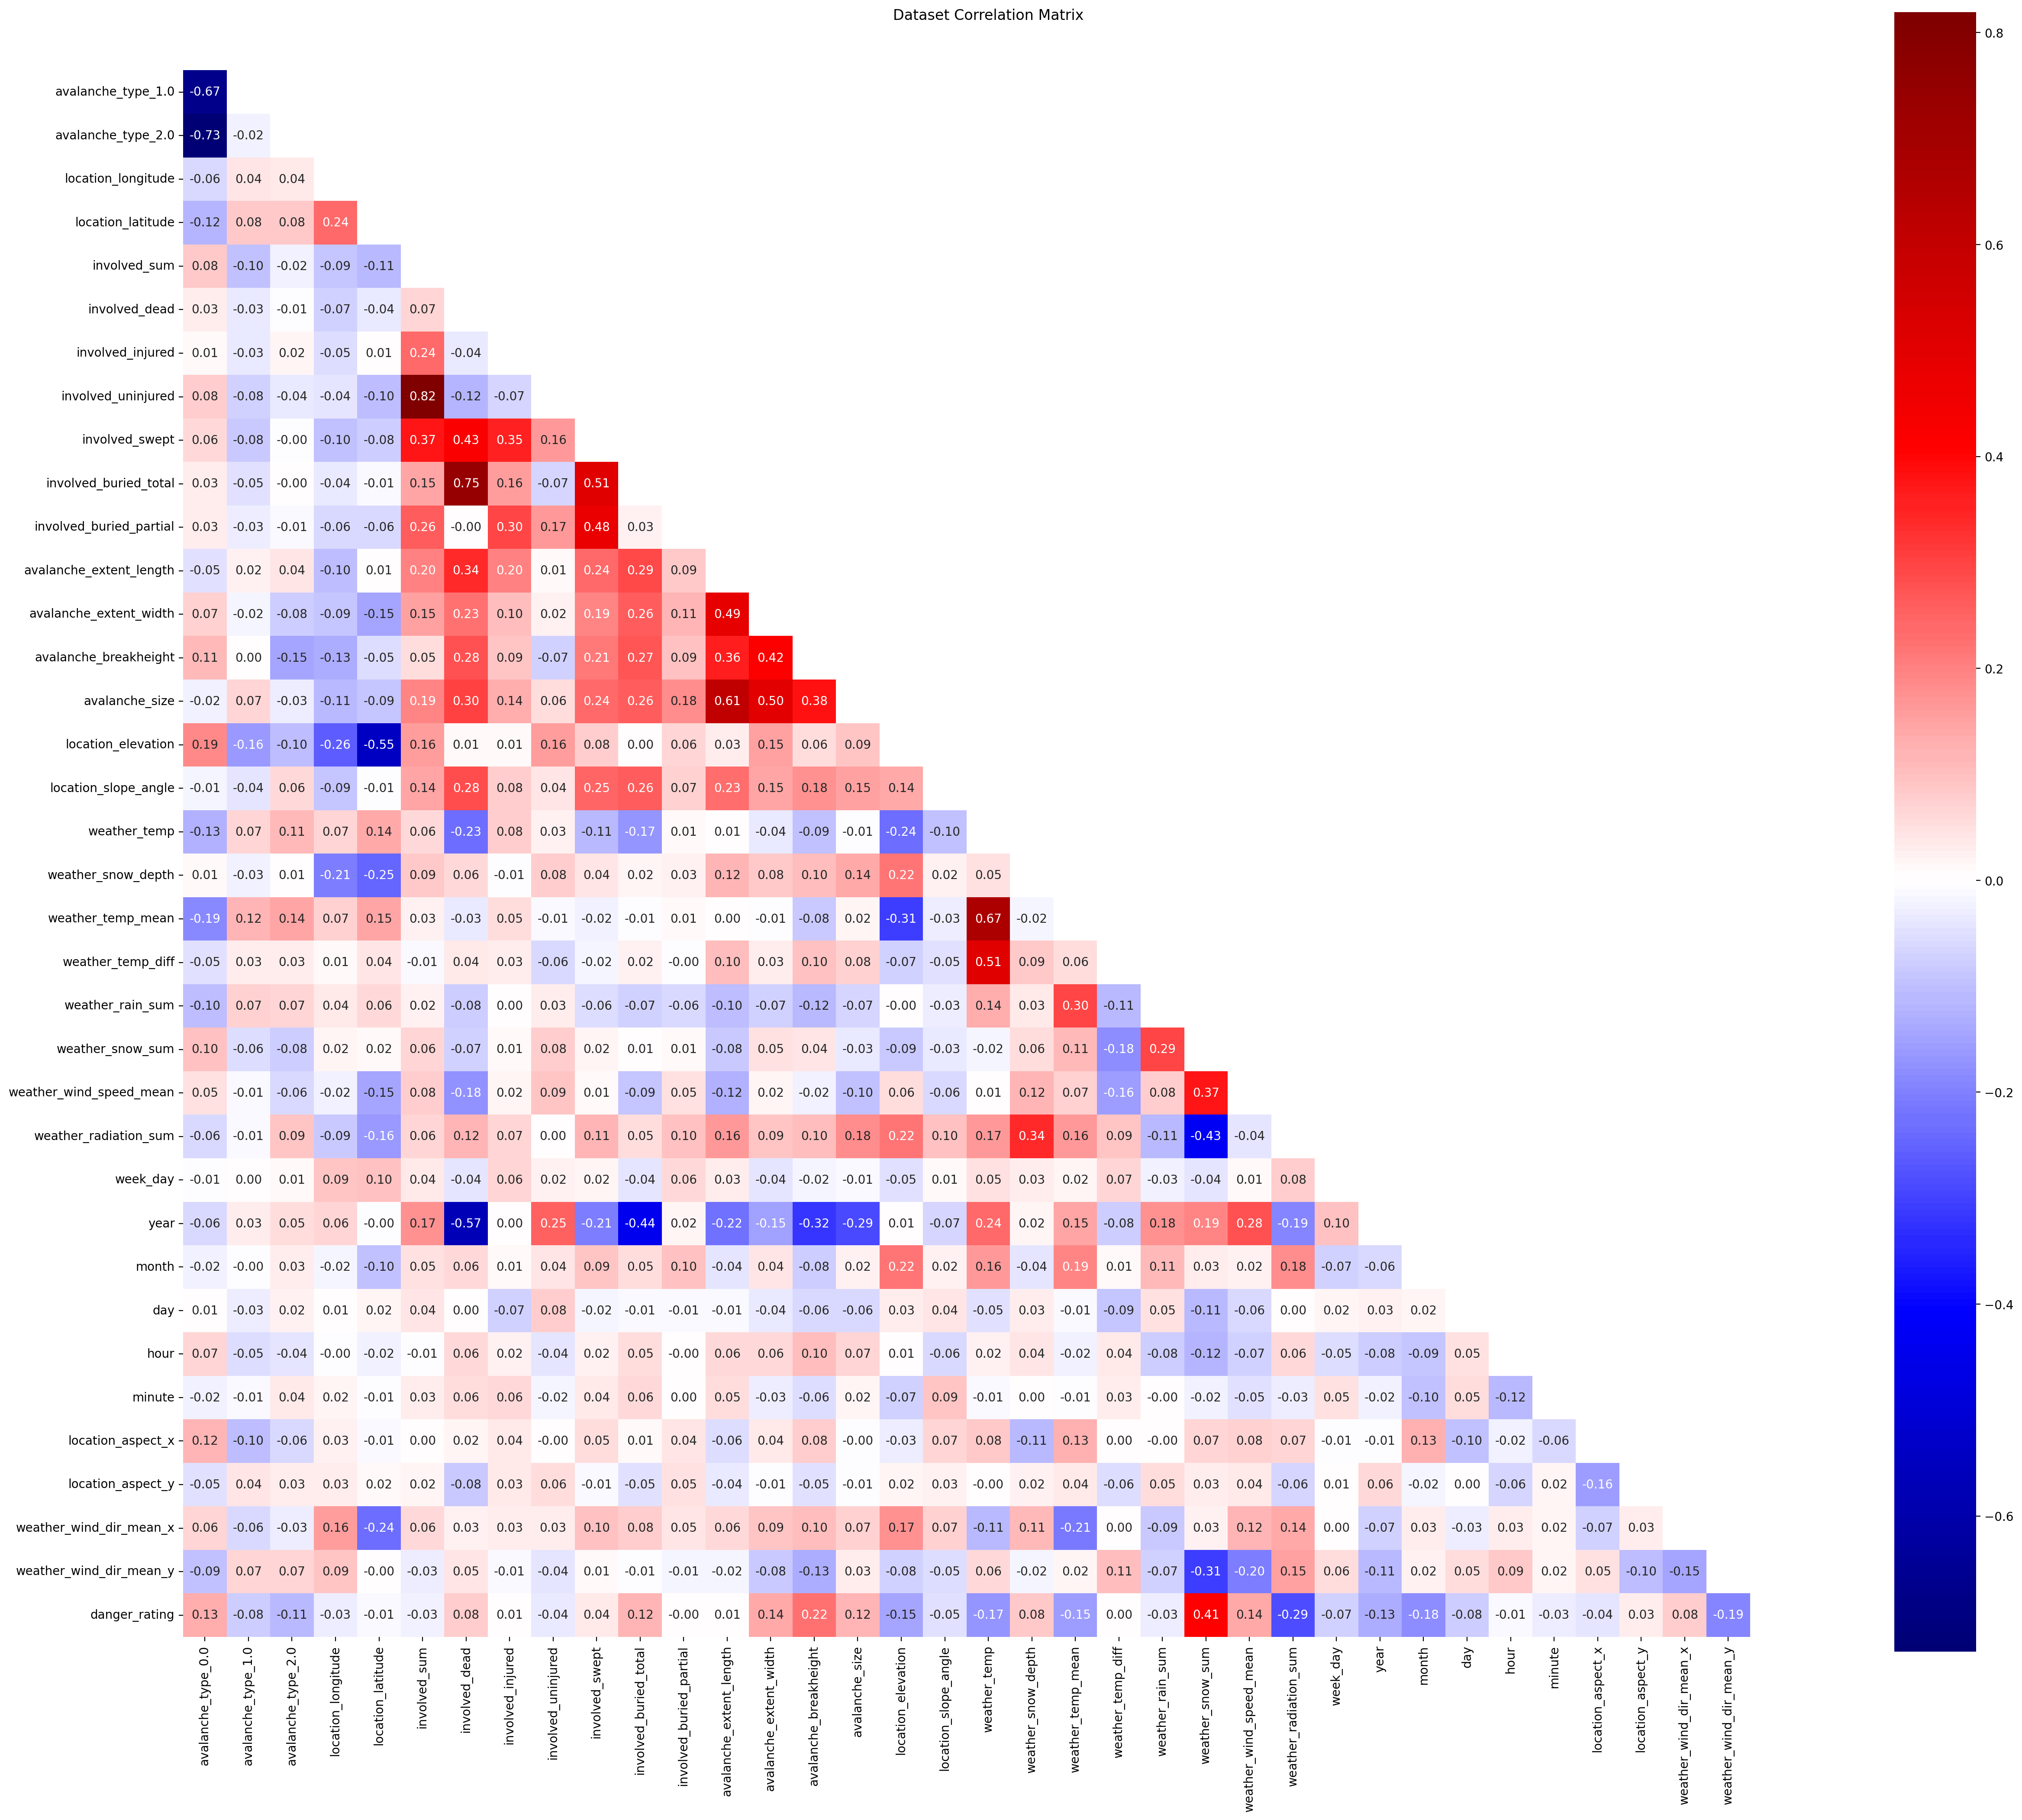

In [44]:
correlation_matrix = imputed_data.corr(method='spearman')
plot_heatmap(correlation_matrix, 'Dataset Correlation Matrix', trimask=True, figsize=(30, 30), color='seismic',
             center=0)
plt.show()

In [45]:
danger_rating_correlations = correlation_matrix['danger_rating'].abs().sort_values(ascending=False).iloc[
                             1:].rename_axis('Feature Name', axis='index')
danger_rating_correlations.name = 'Absolute Correlation Coefficient for the Danger Rating'
danger_rating_correlations

Feature Name
weather_snow_sum           0.414419
weather_radiation_sum      0.286364
avalanche_breakheight      0.224491
weather_wind_dir_mean_y    0.193470
month                      0.180566
weather_temp               0.168057
weather_temp_mean          0.154339
location_elevation         0.145757
weather_wind_speed_mean    0.141536
avalanche_extent_width     0.138417
avalanche_type_0.0         0.134284
year                       0.132856
avalanche_size             0.122897
involved_buried_total      0.122725
avalanche_type_2.0         0.108594
weather_snow_depth         0.083328
day                        0.080657
weather_wind_dir_mean_x    0.078845
involved_dead              0.078490
avalanche_type_1.0         0.078011
week_day                   0.070646
location_slope_angle       0.049925
location_aspect_x          0.039909
involved_uninjured         0.038785
involved_swept             0.037487
location_aspect_y          0.029736
location_longitude         0.028374
minute         

### Splitting the Data

In [46]:
X = imputed_data.drop(columns=['danger_rating'])
y = imputed_data['danger_rating']
unique_value_counts(y, title='Target variable (danger_rating)')

Unique values for the property "Target variable (danger_rating)" (6 unique values and 1054 / 1054 non-null values):



danger_rating
3.0    617
2.0    280
4.0     93
1.0     32
0.0     26
5.0      6
Name: count, dtype: int64

To approximately maintain the value proportions of the value in the target variable after splitting the data between the train and test subsets, the `stratify` parameter is used.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed, stratify=y)

In [48]:
unique_vals = unique_value_counts(y_test, "Danger Rating - Test Dataset")
res = pd.concat([unique_vals, unique_vals / len(y_test) * 100], axis=1)
res.columns = ['Count', 'Share of Total Count (%)']
res

Unique values for the property "Danger Rating - Test Dataset" (6 unique values and 264 / 264 non-null values):



,Count,Share of Total Count (%)
danger_rating,,
3.0,155,58.712121
2.0,70,26.515152
4.0,23,8.712121
1.0,8,3.030303
0.0,7,2.651515
5.0,1,0.378788


In [49]:
unique_vals = unique_value_counts(y_train, "Danger Rating - Training Dataset")
res = pd.concat([unique_vals, unique_vals / len(y_train) * 100], axis=1)
res.columns = ['Count', 'Share of Total Count (%)']
res

Unique values for the property "Danger Rating - Training Dataset" (6 unique values and 790 / 790 non-null values):



,Count,Share of Total Count (%)
danger_rating,,
3.0,462,58.481013
2.0,210,26.582278
4.0,70,8.860759
1.0,24,3.037975
0.0,19,2.405063
5.0,5,0.632911


## Training the Models
### Classifiers
Couple of different classifier were chosen to train on the data to compare and evaluate the best one for our use case:
* Logistic Regression (`LogisticRegression`)
    * This serves as an ideal baseline model due to its common usage as a linear model and its interpretability. It will provide a reference point for comparing other models.
* Support Vector Machines (`SVC`)
    * Given the large number of features, training a model from the support vector machines group is suitable, as these models are effective in higher-dimensional spaces. `SVC` supports various kernels, including non-linear ones, enabling the use of the kernel trick for improved performance.
* Ensemble Models:
    * `RandomForestClassifier`
        * Random Forest was a model that was used in various research papers with from the field of avalanche research. Random forests utilize an ensemble of decision trees, each trained on a different bootstrap sample from the training data and employing random feature selection at each node. The predicted class is the one with highest mean probability estimate across the trees.
    * `XGBClassifier`
        * XGBClassifier is a gradient boosting model that sequentially builds an ensemble of decision trees. Each tree is trained to improve the results of the previous one, aiming for the steepest descent of the cost function. For multiclass classification, such as in our case, the `softmax` function is utilized to minimize cross entropy. The model is robust to overfitting and provides options to prevent it, such as subsampling (controlled by the `subsample` parameter). More information about the model's hyperparameters can be found [here](https://xgboost.readthedocs.io/en/stable/parameter.html).

### Metrics
The main metric used for the hyperparameter tuning was the weighted F1 Score (`sklearn.metrics.f1_score(average='weighted')`). It is calculated as the weighted average of the F1 Scores for each class label, where the weights are their share in the test dataset.
Furthermore, the weighted averages for precision and recall were collected, as well as the balanced accuracy and Cohen Kappa Score.

### Hyperparameter Tuning
For the hyperparameter tuning, the `GridSearchCV` class will be used to exhaustively search for the best hyperparameter combination using cross-validation. The hyperparameters will be selected from this dict:

In [50]:
models_grid = {
    'random_forest': (RandomForestClassifier(random_state=random_seed),
                      {'n_estimators': [100, 200, 300],
                       'max_depth': [None, 10, 20, 30],
                       'min_samples_split': [2, 5, 10],
                       'min_samples_leaf': [1, 2, 4],
                       'max_features': ['log2', 'sqrt']}),
    'xgboost': (XGBClassifier(random_state=random_seed, objective='multi:softmax'),
                {'learning_rate': [0.05, 0.1, 0.2],
                 'n_estimators': [100, 200, 300],
                 'max_depth': [3, 5, 7],
                 'min_child_weight': [1, 3],
                 'subsample': [0.8, 0.9],
                 'colsample_bytree': [0.9, 1.0]}),
    'svc': (SVC(random_state=random_seed, cache_size=512),
            {'C': [1, 10, 20, 50],
             'gamma': ['scale', 'auto'],
             'kernel': ['rbf', 'poly'],
             'class_weight': [None, 'balanced'],
             'degree': [2, 3, 4],
             }),
    'logistic_regression': (LogisticRegression(max_iter=2000, random_state=random_seed, multi_class='auto'),
                            {'C': [2, 10, 20, 50],
                             'solver': ['lbfgs', 'newton_cg'],
                             'penalty': ['l1', 'l2'],
                             'class_weight': [None, 'balanced']
                             })
}

During hyperparameter selection, it's crucial to determine a metric for evaluating the best hyperparameter combination. We'll use the weighted F1 score as the primary metric, given its common use in multiclass classification and its ability to account for both false positives and false negatives, which is particularly beneficial for our imbalanced dataset. Additionally, we'll store both mean recall, mean precision and mean kappa scores computed across all folds, to enable a better informed comparison of the tuned models.

In [51]:
scoring_dict = {
    'F1 Score': make_scorer(f1_score, average='weighted', zero_division=np.nan),
    'Recall': make_scorer(recall_score, average='weighted', zero_division=np.nan),
    'Precision': make_scorer(precision_score, average='weighted', zero_division=np.nan),
    'Kappa Score': make_scorer(cohen_kappa_score),
}

### Dealing with Imbalanced Class Distribution
We observe that the Danger Rating classes are unequally distributed, with the majority (almost 60%) of recorded incidents having the danger rating classified as considerable (3) and just 6 and 25 records for the danger rating very high (5) and not assigned (0) respectively. This imbalance could negatively impact the classification results, with no predictions for the those classes. To mitigate this issue, we can address the data imbalance through oversampling.

The pipeline setup was inspired by [this](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html) blog article.

#### No Oversampling
Given that our training features have different units and as a result different scales, it's crucial to scale the data, particularly for models such as Logistic Regression and SVMs, which are sensitive to feature scales. The `RobustScaler` will be used, as the dataset contains various outliers.

In [52]:
scaler = RobustScaler()

Let's create a base pipeline that will be used for data scaling before fitting every model in the `fit` method of the `GridSearchCV` class.

In [53]:
pipeline_no_oversampling = Pipeline([
    ('scaler', scaler),
])

Proceeding with hyperparameter tuning involves an exhaustive search over all parameter combinations specified in the `models_grid`, which can be time and resource consuming. To address this challenge, we provide the optional `save_prefix` parameter, allowing for the saving of trained and refitted models for future use.

In [54]:
tuned_models_no_oversampling = tune_hyperparameters(models_grid=models_grid, pipeline=pipeline_no_oversampling,
                                                    scoring=scoring_dict,
                                                    X_train=X_train,
                                                    y_train=y_train, save='assets/classification',
                                                    save_prefix='')

Pipeline(steps=[('scaler', RobustScaler()),
                ('model', RandomForestClassifier(random_state=123456))])
Tuning hyperparameters for: random_forest (time: 0.0 s)
Hyperparameter values to test: {'model__n_estimators': [100, 200, 300], 'model__max_depth': [None, 10, 20, 30], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4], 'model__max_features': ['log2', 'sqrt']}
Fitting 4 folds for each of 216 candidates, totalling 864 fits
Tuned model saved at: assets/classification/random_forest_tuned.pkl
Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature

#### Random Oversampling
For the training data obtained with `RandomOverSampler`, the procedure will be similar.

In [55]:
scaler = RobustScaler()
random_sampler = RandomOverSampler(sampling_strategy='auto', random_state=random_seed)

We will add an extra step before training the model, which involves oversampling.

In [56]:
pipeline_random = Pipeline([
    ('scaler', scaler),
    ('random_sampler', random_sampler),
])

In [57]:
tuned_models_random = tune_hyperparameters(models_grid=models_grid, pipeline=pipeline_random, scoring=scoring_dict,
                                           X_train=X_train,
                                           y_train=y_train, save='assets/classification',
                                           save_prefix='random_')

Pipeline(steps=[('scaler', RobustScaler()),
                ('random_sampler', RandomOverSampler(random_state=123456)),
                ('model', RandomForestClassifier(random_state=123456))])
Tuning hyperparameters for: random_forest (time: 0.0 s)
Hyperparameter values to test: {'model__n_estimators': [100, 200, 300], 'model__max_depth': [None, 10, 20, 30], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4], 'model__max_features': ['log2', 'sqrt']}
Fitting 4 folds for each of 216 candidates, totalling 864 fits
Tuned model saved at: assets/classification/random_random_forest_tuned.pkl
Pipeline(steps=[('scaler', RobustScaler()),
                ('random_sampler', RandomOverSampler(random_state=123456)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
             

#### ADASYN Oversampling

In [58]:
scaler = RobustScaler()
adasyn_sampler = ADASYN(sampling_strategy='auto', random_state=random_seed, n_neighbors=2)

In [59]:
pipeline_adasyn = Pipeline([
    ('scaler', scaler),
    ('adasyn_sampler', adasyn_sampler),
])

In [60]:
tuned_models_adasyn = tune_hyperparameters(models_grid=models_grid, pipeline=pipeline_adasyn, scoring=scoring_dict,
                                           X_train=X_train,
                                           y_train=y_train, save='assets/classification',
                                           save_prefix='adasyn_')

Pipeline(steps=[('scaler', RobustScaler()),
                ('adasyn_sampler', ADASYN(n_neighbors=2, random_state=123456)),
                ('model', RandomForestClassifier(random_state=123456))])
Tuning hyperparameters for: random_forest (time: 0.0 s)
Hyperparameter values to test: {'model__n_estimators': [100, 200, 300], 'model__max_depth': [None, 10, 20, 30], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4], 'model__max_features': ['log2', 'sqrt']}
Fitting 4 folds for each of 216 candidates, totalling 864 fits
Tuned model saved at: assets/classification/adasyn_random_forest_tuned.pkl
Pipeline(steps=[('scaler', RobustScaler()),
                ('adasyn_sampler', ADASYN(n_neighbors=2, random_state=123456)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
     

## Model Performance Evalution
To compare the tuned models, we will allow each one of them to make predictions on previously unseen test data. We will compute the accuracy, weighted F1 score, weighted precision, weighted recall, and kappa score for each model's prediction.

### Training Data Without Oversampling

In [61]:
y_pred_no_oversampling, predict_stats_no_oversampling = get_model_predict_comparison(tuned_models_no_oversampling,
                                                                                     X_test, y_test)
predict_stats_no_oversampling   

,random_forest,xgboost,svc,logistic_regression
Metric,,,,
F1-score,0.671683,0.687709,0.606193,0.642250
Precision,0.721936,0.690338,0.616814,0.645184
Recall,0.708333,0.700758,0.643939,0.666667
Cohen Kappa Score,0.406707,0.443499,0.294980,0.359082
Balanced Accuracy,0.328547,0.434534,0.270691,0.377445


As we can see, the ensemble models are the best-performing overall, scoring higher than `SVC` and `LogisticRegression` in almost all measured metrics. Both have decnt F1 Score, with `XGBClassifier` having 0.69 and `RandomForestClassifier` 0.67 respectivelly. Their results in weighted precision, recall score are very similar. The `XGBClassifier` outperformed the rest in the Kappa Score, indicating that it has the best agreement ratio between predicted and actual labels beyond the chance.

### Randomly Oversampled Training Data

In [62]:
y_pred_random, predict_stats_random = get_model_predict_comparison(tuned_models_random, X_test, y_test)
predict_stats_random

,random_forest,xgboost,svc,logistic_regression
Metric,,,,
F1-score,0.743411,0.687287,0.612045,0.546077
Precision,0.762903,0.686184,0.609158,0.649374
Recall,0.757576,0.693182,0.617424,0.507576
Cohen Kappa Score,0.550531,0.450551,0.314744,0.293507
Balanced Accuracy,0.473154,0.468765,0.552072,0.444261


For randomly oversampled data random forest significantly outperformed other models. In all metrics except the balanced accuracy it outperformed the other models by a big margin. The performance of logistic regression decreased.

### ADASYN Oversampled Training Data

In [63]:
y_pred_adasyn, predict_stats_adasyn = get_model_predict_comparison(tuned_models_adasyn, X_test, y_test)
predict_stats_adasyn

,random_forest,xgboost,svc,logistic_regression
Metric,,,,
F1-score,0.722870,0.728438,0.620525,0.544853
Precision,0.737888,0.726665,0.619328,0.628246
Recall,0.738636,0.738636,0.625000,0.511364
Cohen Kappa Score,0.520215,0.526390,0.330653,0.284237
Balanced Accuracy,0.439595,0.449622,0.550298,0.441419


### Models Comparison over Different Oversampling
The ensemble models are the best-performing overall, scoring higher than the other models in most of the measured metrics.

In [64]:
oversampling_comparison = pd.concat(
    [predict_stats_no_oversampling['xgboost'], predict_stats_random['random_forest'],
     predict_stats_adasyn['xgboost']],
    axis=1)
oversampling_comparison.columns = ['XGBClassifier without Oversampling',
                                   'RandomForestClassifier with Random Oversampling',
                                   'XGBClassifier with ADASYN']
oversampling_comparison

,XGBClassifier without Oversampling,RandomForestClassifier with Random Oversampling,XGBClassifier with ADASYN
Metric,,,
F1-score,0.687709,0.743411,0.728438
Precision,0.690338,0.762903,0.726665
Recall,0.700758,0.757576,0.738636
Cohen Kappa Score,0.443499,0.550531,0.526390
Balanced Accuracy,0.434534,0.473154,0.449622


As the best classifiers for each training dataset, both the `XGBoostClassifier` were selected for the training dataset with ADASYN oversampled data as well as for the training set without oversampling. Additionally, from the models trained on the data without oversampling, the `RandomForestClassifier` was selected.

The `XGBClassifier` trained without oversampling performs the worst in this comparison, displaying lower values in all observed metrics. However, oversampling generally helped to boost the performance of the models. The best overall performer was the random forest model trained on the randomly oversampled data, achieving an F1 Score of 0.74, with decent levels of both precision and recall, indicating it does not output false positives nor false negatives often. The Kappa Score is lower at 0.55, suggesting a moderate level of agreement beyond chance.

Although the `RandomForestClassifier` trained on randomly oversampled data slightly outperforms the ADASYN `XGBClassifier`, both behave very similarly, and their performance could differ on different subsets of the test data.

In [65]:
selected_model = tuned_models_random['random_forest']['model']
selected_scaler = tuned_models_random['random_forest']['scaler']
selected_model_pred = y_pred_random['random_forest']

### Confusion Matrix

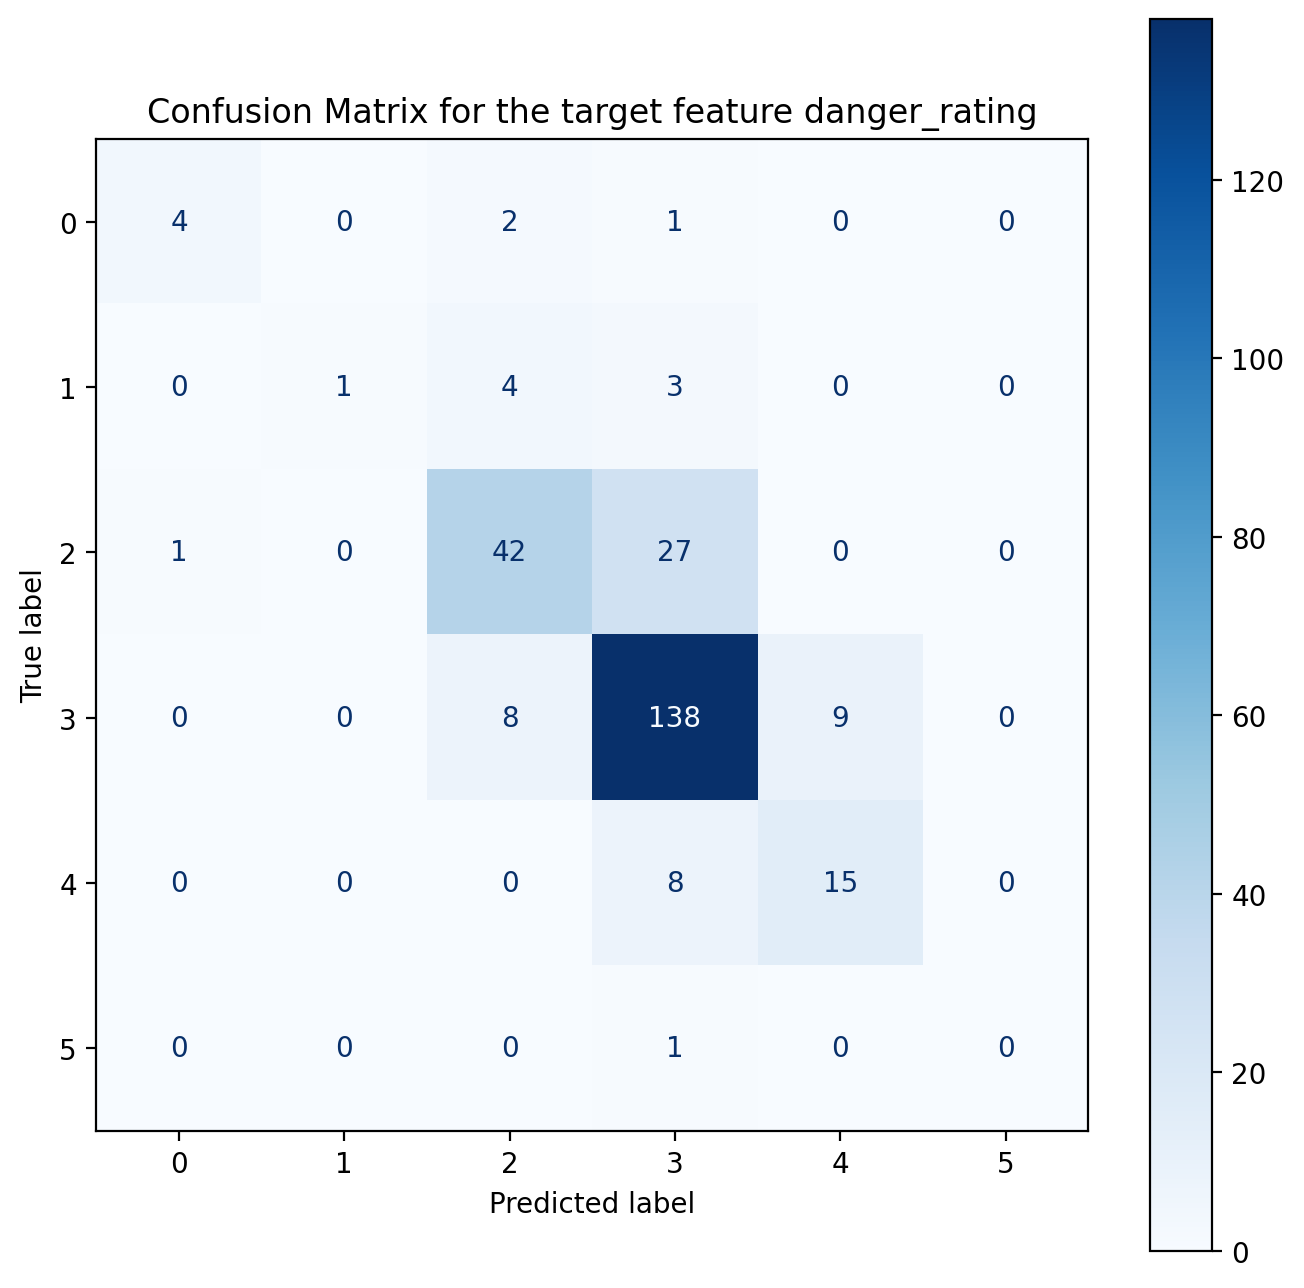

In [66]:
plot_confusion_matrix(y_true=y_test, y_pred=selected_model_pred, target_name='danger_rating', color='Blues')
plt.show()

In [67]:
_, class_metrics = calculate_performance_metrics(y_true=y_test, y_pred=selected_model_pred, class_metrics=True)
class_metrics

,precision,recall,f1-score,support
0.0,0.800000,0.571429,0.666667,7.0
1.0,1.000000,0.125000,0.222222,8.0
2.0,0.750000,0.600000,0.666667,70.0
3.0,0.775281,0.890323,0.828829,155.0
4.0,0.625000,0.652174,0.638298,23.0
5.0,NaN,0.000000,0.000000,1.0


The label that gets predicted wrong the most times is the danger rating 2, that the model confuses with 3. 
Also for the danger rating 1, the model only predicted right one time out of 8, the rest of the records were predicted with higher ratings. Besides that it performs quite well when predicting danger rating 3 with a high number of true positives. The danger rating 3 is also the label with the highest support (records in the test set).

### Final Note
There is only one incident with danger rating 5, which is way too little for a comprehensive analysis, as [[source](https://nhess.copernicus.org/articles/22/2031/2022/)] suggests, it could be merged into one danger rating together with 4 to improve the results.

The dataset lacks information on further crucial factors, such as the snowpack structure and other data measured during the creation of the snow profile. Snow profile interpretation is a challenging task that mostly relies on the judgment of experts. [[source](https://www.slf.ch/en/avalanche-bulletin-and-snow-situation/snow-maps/information-about-snow-profiles/)] Including this additional data could further improve the model's performance. Additionally, there are a large number of records with a significant proportion of missing values. Moreover, almost two-thirds of the dataset contains invalid location records, making it impossible to fill the missing geographical data accurately.